# Node classification with keras

alternatives:
- http://vlado.fmf.uni-lj.si/pub/networks/data/bio/Yeast/Yeast.htm
- https://paperswithcode.com/dataset/yeast
- https://paperswithcode.com/dataset/wiki-cs
- https://paperswithcode.com/dataset/pubmed
- https://paperswithcode.com/datasets?mod=graphs&task=node-classification
- http://www-personal.umich.edu/~mejn/netdata/
- https://studentwork.prattsi.org/infovis/visualization/les-miserables-character-network-visualization/

Uses the tutorial at StellarGraph as a start: https://stellargraph.readthedocs.io/en/stable/demos/node-classification/keras-node2vec-node-classification.html

In [1]:
import numpy as np
from IPython.core.display_functions import display
from igraph import Graph
from ipywidgets import HTML
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from stellargraph.data import BiasedRandomWalk, UnsupervisedSampler
from stellargraph.datasets import datasets
from stellargraph.layer import Node2Vec, link_classification
from stellargraph.mapper import Node2VecLinkGenerator, Node2VecNodeGenerator
from tensorflow import keras

from lib.DataSet import DataSet
from lib.ProjectGraph import init_stellar_graph, retain_largest_category, init_igraph, largest_component

2022-05-22 08:09:18.345439: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Datasets

### Alternative datasets

#### Yeast

See:
- https://paperswithcode.com/dataset/yeast
- http://vlado.fmf.uni-lj.si/pub/networks/data/bio/Yeast/Yeast.htm

Files:
- yeastS.net    -> X interacts with Y relation, short names.
- yeastL.net    -> X interacts with Y relation, long labels.
- yeast.clu     -> PIN class partition of vertices, see encoding.
- yeast.paj     -> Pajek project file with complete dataset.

In [2]:
yeast: Graph = Graph.Read('./data/yeast/YeastS.net')
yeast.summary()

'IGRAPH UN-- 2361 7182 -- \n+ attr: id (v), name (v)'

In [3]:
yeast: Graph = Graph.Read('./data/yeast/Yeast.paj', format='pajek')
yeast.summary()

InternalError: Error at src/io/pajek.c:168: Parse error in Pajek file, line 1 (syntax error, unexpected NEWLINE, expecting VERTICESLINE). -- Parse error

#### Les Misérables

In [ ]:
g: Graph = Graph.Read('./data/lesmis/lesmis.gml')
g.summary()

In [ ]:
# len(g.vs.get_attribute_values("id"))
len(g.vs.get_attribute_values("label"))

### Regular datasets

In [ ]:
dataset = datasets.Cora()
display(HTML(dataset.description))
graph, subjects = dataset.load(largest_connected_component_only=True)

In [ ]:
print(graph.info())

In [4]:
hosap_data = DataSet('./data/Homo_sapiens.mat')

In [ ]:
np.max(hosap_data.network[3,:])

In [ ]:

# g: Graph = Graph.Read_Adjacency('././data/Homo_sapiens.mat')
g: Graph = Graph.Adjacency(hosap_data.network)
g.summary()

In [ ]:


# experiments with igraph components
hosap_data = DataSet('./data/Homo_sapiens.mat')
hosap_graph = init_igraph(hosap_data)
hosap_graph.summary()

In [ ]:

hosap_graph = largest_component(hosap_graph)
hosap_graph.summary()

Choose which dataset to use:

In [ ]:
data = DataSet('./data/Homo_sapiens.mat')
# data = DataSet('./data/POS.mat')

Initialize iGraph:

In [ ]:
graph = init_igraph(data, only_largest_component=True)
graph.summary()

Only use the category data of the largest category (given that categories are not unique):

In [ ]:
# graph.get_vertex_dataframe()['category'].to_numpy()

In [4]:
labels, graph = retain_largest_category(graph)
graph.summary()

NameError: name 'graph' is not defined

In [5]:
labels

NameError: name 'labels' is not defined

Convert to StellarGraph:

In [6]:
# which p/q values to explore
# p_values = np.append(
#     np.arange(0.1, 1.0, 0.1),
#     np.arange(1, 11, 1)
# )
# q_values = p_values.copy()
p_values = np.array([0.5, 2])
q_values = np.array([0.5, 2])

graph = init_stellar_graph(graph)
print(graph.info())

NameError: name 'graph' is not defined

Limit the category labels to the largest category only since the category labels are not exclusive:

In [7]:
# from lib.ProjectGraph import retain_largest_category
#
# labels, graph = retain_largest_category(graph)

Configure a random walker to generate sentences for node2vec

In [8]:
# walker = BiasedRandomWalk(
#     graph,
#     n=100,
#     length=5,
#     p=0.5,  # defines probability, 1/p, of returning to source node
#     q=2.0,  # defines probability, 1/q, for moving to a node away from the source node
# )
walker = BiasedRandomWalk(
    graph,
    n=50,
    length=5,
    p=2.0,  # defines probability, 1/p, of returning to source node
    q=1.0,  # defines probability, 1/q, for moving to a node away from the source node
)

NameError: name 'graph' is not defined

Create a sampler with the walker (this generates positive and negative samples for our algorithm):

In [9]:
unsupervised_samples = UnsupervisedSampler(graph, nodes=list(graph.nodes()), walker=walker)

NameError: name 'graph' is not defined

In [10]:
batch_size = 50
epochs = 2

generator = Node2VecLinkGenerator(graph, batch_size)

NameError: name 'graph' is not defined

In [11]:
# emb_size = 128
emb_size = 128
node2vec = Node2Vec(emb_size, generator=generator)

NameError: name 'generator' is not defined

In [12]:
x_inp, x_out = node2vec.in_out_tensors()

NameError: name 'node2vec' is not defined

In [13]:
prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="dot"
)(x_out)

link_classification: using 'dot' method to combine node embeddings into edge embeddings


NameError: name 'x_out' is not defined

In [14]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)

NameError: name 'x_inp' is not defined

In [15]:
history = model.fit(
    generator.flow(unsupervised_samples),
    epochs=epochs,
    verbose=1,
    use_multiprocessing=False,
    workers=4,
    shuffle=True,
)

NameError: name 'model' is not defined

# Node prediction model

Builds the node prediction model using the node2vec embeddings

In [60]:
x_inp_src = x_inp[0]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

Access the node embeddings

In [61]:
# subjects = graph.retain_largest_category()
node_ids = graph.nodes()
# node_count = largest_y.shape[0]
# node_ids = np.arange(0,node_count)
# subjects = largest_y

Should return count of node ids

In [62]:
node_ids

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            3842, 3843, 3844, 3845, 3846, 3847, 3848, 3849, 3850, 3851],
           dtype='int64', length=3852)

Should return an nx1 array with category labels:

In [63]:
# subjects

In [64]:
# p = -1
# for n in graph.nodes():
#     if n > (p + 1):
#         print("Skipping node {}".format(p+1))
#
#     p = n


In [65]:
# subjects

In [66]:
# hosap_data.group[:,1]
# largest_y_index[0]

In [67]:
# original
# node_gen = Node2VecNodeGenerator(graph, batch_size).flow(subjects.index)
# node_embeddings = embedding_model.predict(node_gen, workers=4, verbose=1)

In [68]:
batch_size = 50
node_gen = Node2VecNodeGenerator(graph, batch_size).flow(node_ids)
node_embeddings = embedding_model.predict(node_gen, workers=4, verbose=1)

78/78 [==============================] - 0s 2ms/step


## Visualization

In [69]:
transform = TSNE  # PCA

trans = transform(init='pca', n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

/Users/jamescauwelier/Library/Caches/pypoetry/virtualenvs/graph-classification-experiments-RDFHJCIl-py3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/jamescauwelier/Library/Caches/pypoetry/virtualenvs/graph-classification-experiments-RDFHJCIl-py3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


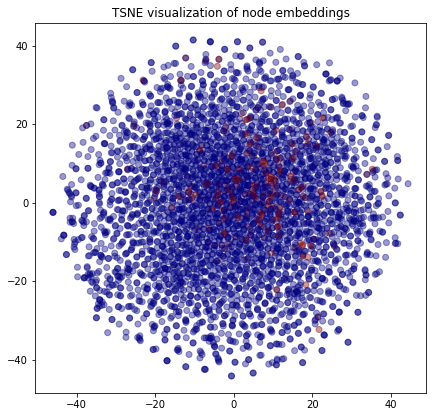

In [70]:
# draw the embedding points, coloring them by the target label (paper subject)
alpha = 0.4
label_map = {l: i for i, l in enumerate(np.unique(labels))}
node_colours = [label_map[target] for target in labels]

plt.figure(figsize=(7, 7))
plt.axes().set(aspect="equal")
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
plt.title("{} visualization of node embeddings".format(transform.__name__))
plt.show()

## Predicting node classes

In [71]:
# X will hold the 128-dimensional input features
X = node_embeddings
# y holds the corresponding target values
y = np.array(labels)

In [72]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, test_size=None)
print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

Array shapes:
 X_train = (1926, 128)
 y_train = (1926,)
 X_test = (1926, 128)
 y_test = (1926,)


### Classifier training

In [73]:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(
    Cs=10, cv=10, scoring="f1_macro", verbose=False, multi_class="ovr", max_iter=1000
)
clf.fit(X_train, y_train)

LogisticRegressionCV(cv=10, max_iter=1000, multi_class='ovr',
                     scoring='f1_macro', verbose=False)

Predict the hold-out test group

In [74]:
y_pred = clf.predict(X_test)

Calculate the accuracy:

In [75]:
from sklearn.metrics import accuracy_score, f1_score

accuracy_score(y_test, y_pred)

0.935098650051921

In [76]:
f1_score(y_test, y_pred, average='micro')

0.935098650051921

In [77]:
f1_score(y_test, y_pred, average='macro')

0.5636587058923745

## Putting it all together

In [16]:
hosap_data = DataSet('./data/Homo_sapiens.mat')

# initializes igraph from data file
hosap_graph = init_igraph(hosap_data, only_largest_component=True)
hosap_graph.summary()

# retain only the largest category labels
labels, igraph = retain_largest_category(hosap_graph)
igraph.summary()

graph = init_stellar_graph(igraph)
print(graph.info())

StellarGraph: Undirected multigraph
 Nodes: 3852, Edges: 38705

 Node types:
  default: [3852]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [38705]
        Weights: all 1 (default)
        Features: none


In [17]:
# which p/q values to explore
# p_values = np.append(
#     np.arange(0.1, 1.0, 0.1),
#     np.arange(1, 11, 1)
# )
# q_values = p_values.copy()
p_values = np.array([0.5, 2])
q_values = np.array([0.5, 2])



In [18]:
import pandas as pd
import igraph as ig
from stellargraph import StellarGraph


def init_stellar_graph2(graph: Graph) -> StellarGraph:

    # prepare graph data format
    edge_list = np.array(ig.Graph.get_edgelist(graph))
    sources = edge_list[:, 0]
    targets = edge_list[:, 1]

    # compose into expected format
    edges = pd.DataFrame(
        {"source": sources, "target": targets}
    )

    # get nodes with category feature
    nodes = graph.vs.get_attribute_values('category')

    # init
    stellar = StellarGraph(nodes=nodes, edges=edges)

    return stellar

# g2: StellarGraph = init_stellar_graph2(igraph)
# g2.info()

nx = igraph.to_networkx()
stellarnx = StellarGraph.from_networkx(nx)
print(stellarnx.info())

StellarGraph: Undirected multigraph
 Nodes: 3852, Edges: 38705

 Node types:
  default: [3852]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [38705]
        Weights: all 1 (default)
        Features: none


Configure a random walker:

In [136]:
class Word2VecResult:

    embeddings = None

    def __init__(self, embeddings):
        self.embeddings = embeddings

def word2vec_run(graph: StellarGraph, **kwargs) -> Word2VecResult:

    walker_config = {

        # Defines default random walker config (used during testing)
        'n': 5,            # n         --> total number of random walks per node
        'length': 25,        # length    --> Maximum length of each random walk
        'p': 1.0,           # p         --> Defines probability, 1/p, of returning to source node
        'q': 1.0,           # q         --> Defines probability, 1/q, for moving to a node away from the source node

        # overrides previous configurations
        **kwargs
    }

    # print("Q should be {}, but is {}".format(kwargs['q'], walker_config['q']))

    node2vec_config = {

        # Node2Vec link generator config
        'batch_size': 50,
        'epochs': 2,
        'embedding_size': 128,

        'learning_rate': 1e-3,
        'epsilon': 1e-7,
        'momentum': 0.01,

        # overrides previous configurations
        **kwargs
    }

    # configure a random walker
    walker = BiasedRandomWalk(
        graph,
        n=walker_config['n'],
        length=walker_config['length'],
        p=walker_config['p'],
        q=walker_config['q'],
    )

    # sampler
    unsupervised_samples = UnsupervisedSampler(graph, nodes=list(graph.nodes()), walker=walker)

    #
    generator = Node2VecLinkGenerator(graph, node2vec_config['batch_size'])

    node2vec = Node2Vec(node2vec_config['embedding_size'], generator=generator)

    x_inp, x_out = node2vec.in_out_tensors()

    prediction = link_classification(
        output_dim=1, output_act="sigmoid", edge_embedding_method="dot"
    )(x_out)

    sgd_optimizer = keras.optimizers.SGD(
        learning_rate=node2vec_config['learning_rate'], momentum=node2vec_config['momentum'], nesterov=False, name="SGD"
    )
    adam_optimizer = keras.optimizers.Adam(learning_rate=node2vec_config['learning_rate'], epsilon=node2vec_config['epsilon'])

    model = keras.Model(inputs=x_inp, outputs=prediction)
    model.compile(
        optimizer=adam_optimizer,
        loss=keras.losses.binary_crossentropy,
        metrics=[keras.metrics.binary_accuracy],
    )

    history = model.fit(
        generator.flow(unsupervised_samples),
        epochs=node2vec_config['epochs'],
        verbose=1,
        use_multiprocessing=False,
        workers=4,
        shuffle=True,
    )

    #
    # NODE PREDICTION MODEL
    #

    x_inp_src = x_inp[0]
    x_out_src = x_out[0]
    embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

    node_ids = graph.nodes()

    node_gen = Node2VecNodeGenerator(graph, node2vec_config['batch_size']).flow(node_ids)
    node_embeddings = embedding_model.predict(node_gen, workers=4, verbose=1)

    return Word2VecResult(
        embeddings=node_embeddings
    )



In [20]:
results = word2vec_run(stellarnx)
results.embeddings

link_classification: using 'dot' method to combine node embeddings into edge embeddings
Epoch 1/2
30816/30816 [==============================] - 115s 4ms/step - loss: 0.6753 - binary_accuracy: 0.5743


KeyboardInterrupt: 

Balancing class values:

In [11]:
results.embeddings.shape

(3852, 128)

In [12]:
labels.shape

(3852,)

In [13]:
# np.unique(labels)
# np.where()

positives = np.where(labels == 1)[0]
positives

array([  18,   22,   38,   69,  118,  140,  202,  228,  274,  278,  318,
        376,  378,  387,  398,  408,  419,  430,  431,  432,  434,  440,
        532,  557,  570,  631,  638,  643,  659,  666,  669,  686,  694,
        700,  716,  718,  720,  766,  812,  822,  823,  828,  840,  866,
        895,  903,  939,  952,  955,  996, 1011, 1016, 1063, 1064, 1067,
       1068, 1069, 1074, 1088, 1089, 1090, 1092, 1094, 1098, 1126, 1145,
       1147, 1193, 1201, 1223, 1237, 1243, 1246, 1259, 1278, 1321, 1326,
       1329, 1345, 1346, 1358, 1360, 1373, 1398, 1406, 1440, 1479, 1487,
       1500, 1513, 1555, 1584, 1585, 1588, 1589, 1593, 1614, 1632, 1683,
       1735, 1754, 1771, 1788, 1825, 1832, 1881, 1894, 1912, 1958, 1961,
       2058, 2092, 2103, 2142, 2146, 2169, 2177, 2178, 2239, 2251, 2262,
       2267, 2271, 2315, 2359, 2439, 2457, 2460, 2462, 2464, 2465, 2466,
       2468, 2498, 2511, 2534, 2547, 2548, 2551, 2557, 2568, 2589, 2610,
       2731, 2755, 2771, 2785, 2795, 2833, 2863, 29

In [14]:
negatives = np.where(labels != 1)[0]
negatives

array([   0,    1,    2, ..., 3849, 3850, 3851])

In [15]:

np.min([np.size(positives), np.size(negatives)])

197

In [16]:
np.size(positives)

197

In [17]:
from sklearn.utils._random import sample_without_replacement

# sample_without_replacement(n_population=np.size(negatives), n_samples=np.size(positives))
s = sample_without_replacement(n_population=np.size(negatives), n_samples=3)
s

array([ 575,  500, 2946])

In [18]:
negatives[s]

array([ 600,  522, 3103])

In [19]:
a = np.array([1, 3, 5])
b = np.array([7, 9])

np.append(a, b)

array([1, 3, 5, 7, 9])

In [23]:


from lib.ProjectGraph import balance

balanced_embeddings, balanced_labels = balance(results.embeddings, labels)

NameError: name 'results' is not defined

In [24]:
balanced_embeddings.shape

NameError: name 'balanced_embeddings' is not defined

In [24]:
balanced_labels.shape

(394,)

Class prediction (training + performance assessment):

In [25]:
from sklearn.linear_model import LogisticRegression
from dataclasses import dataclass


@dataclass
class PredictionPerformance:

    description: str
    accuracy: float
    f1_micro: float
    f1_macro: float


def predict_node_classes(X, y, description='Node prediction results', scoring="accuracy") -> PredictionPerformance:

    # X will hold the 128-dimensional input features
    # X = node_embeddings
    # y holds the corresponding target values
    # y = np.array(labels)

    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, test_size=None)
    # print(
    #     "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
    #         X_train.shape, y_train.shape, X_test.shape, y_test.shape
    #     )
    # )

    # training

    from sklearn.linear_model import LogisticRegressionCV

    # clf = LogisticRegressionCV(
    #     Cs=10, cv=10, scoring=scoring, penalty="l2", solver="liblinear", verbose=False, multi_class="ovr", max_iter=1000, random_state=1
    # )
    clf = LogisticRegression(
        penalty="l2", solver="liblinear", verbose=False, multi_class="ovr", max_iter=1000, random_state=1, tol=1e-7, C=0.05
    )
    clf.fit(X_train, y_train)

    # predicting

    y_pred = clf.predict(X_test)

    # scoring
    from sklearn.metrics import accuracy_score, f1_score

    return PredictionPerformance(
        description=description,
        accuracy=accuracy_score(y_test, y_pred),
        f1_micro=f1_score(y_test, y_pred, average='micro'),
        f1_macro=f1_score(y_test, y_pred, average='macro')
    )

In [26]:
# result = predict_node_classes(results.embeddings, labels)
# result

In [91]:
from scipy.sparse import csc_matrix
from scipy.io import loadmat

hs = loadmat('./data/Homo_sapiens.mat', matlab_compatible=True)

# network = np.array(csc_matrix(hs['network'], dtype=int).toarray())
group = np.array(csc_matrix(hs['group'], dtype=int).toarray())

# network_graph: Graph = Graph.Adjacency(csc_matrix(hs['network'], dtype=float), mode="undirected")
network_graph: Graph = Graph.Weighted_Adjacency(hs['network'], mode="undirected", loops=False)
network_graph: Graph = largest_component(network_graph)

# prepare graph data format
edge_list = np.array(network_graph.get_edgelist())
# sources = edge_list[:, 0]
# targets = edge_list[:, 1]

# compose into expected format
# edges = pd.DataFrame(
#     {"source": sources, "target": targets}
# )

# get nodes with category feature
# nodes = graph.vs.get_attribute_values('category')

# init
simple_edges = pd.DataFrame(data=edge_list, columns=['source', 'target'])
# stellartest = StellarGraph(edges=simple_edges, is_directed=False, nodes=group)
stellartest = StellarGraph(edges=simple_edges, is_directed=False)
print(stellartest.info())

StellarGraph: Undirected multigraph
 Nodes: 3852, Edges: 37841

 Node types:
  default: [3852]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [37841]
        Weights: all 1 (default)
        Features: none


In [92]:
from lib.ProjectGraph import balance

In [98]:
lesmis: Graph = Graph.Load('./data/lesmis/lesmis.gml')
print(lesmis.summary())

IGRAPH U--- 77 254 -- 
+ attr: id (v), label (v), value (e)


In [106]:
lesmis_edges = pd.DataFrame(data=lesmis.get_edgelist(), columns=['source', 'target'])
lesmis_stellar = StellarGraph(edges=lesmis_edges, is_directed=False)
lesmis.vs.get_attribute_values('label')

['Myriel',
 'Napoleon',
 'MlleBaptistine',
 'MmeMagloire',
 'CountessDeLo',
 'Geborand',
 'Champtercier',
 'Cravatte',
 'Count',
 'OldMan',
 'Labarre',
 'Valjean',
 'Marguerite',
 'MmeDeR',
 'Isabeau',
 'Gervais',
 'Tholomyes',
 'Listolier',
 'Fameuil',
 'Blacheville',
 'Favourite',
 'Dahlia',
 'Zephine',
 'Fantine',
 'MmeThenardier',
 'Thenardier',
 'Cosette',
 'Javert',
 'Fauchelevent',
 'Bamatabois',
 'Perpetue',
 'Simplice',
 'Scaufflaire',
 'Woman1',
 'Judge',
 'Champmathieu',
 'Brevet',
 'Chenildieu',
 'Cochepaille',
 'Pontmercy',
 'Boulatruelle',
 'Eponine',
 'Anzelma',
 'Woman2',
 'MotherInnocent',
 'Gribier',
 'Jondrette',
 'MmeBurgon',
 'Gavroche',
 'Gillenormand',
 'Magnon',
 'MlleGillenormand',
 'MmePontmercy',
 'MlleVaubois',
 'LtGillenormand',
 'Marius',
 'BaronessT',
 'Mabeuf',
 'Enjolras',
 'Combeferre',
 'Prouvaire',
 'Feuilly',
 'Courfeyrac',
 'Bahorel',
 'Bossuet',
 'Joly',
 'Grantaire',
 'MotherPlutarch',
 'Gueulemer',
 'Babet',
 'Claquesous',
 'Montparnasse',
 'Tou

In [102]:
word2vec_results: Word2VecResult = word2vec_run(lesmis_stellar, n=100, length=10, p=0.5, q=1.0, epochs=10)

link_classification: using 'dot' method to combine node embeddings into edge embeddings
Epoch 1/10
2772/2772 [==============================] - 3s 1ms/step - loss: 0.6120 - binary_accuracy: 0.6550
Epoch 2/10
2772/2772 [==============================] - 3s 1ms/step - loss: 0.5589 - binary_accuracy: 0.7132
Epoch 3/10
2772/2772 [==============================] - 3s 1ms/step - loss: 0.5590 - binary_accuracy: 0.7113
Epoch 4/10
2772/2772 [==============================] - 3s 1ms/step - loss: 0.5602 - binary_accuracy: 0.7107
Epoch 5/10
2772/2772 [==============================] - 3s 1ms/step - loss: 0.5592 - binary_accuracy: 0.7092
Epoch 6/10
2772/2772 [==============================] - 3s 1ms/step - loss: 0.5578 - binary_accuracy: 0.7124
Epoch 7/10
2772/2772 [==============================] - 3s 1ms/step - loss: 0.5591 - binary_accuracy: 0.7104
Epoch 8/10
2772/2772 [==============================] - 3s 1ms/step - loss: 0.5572 - binary_accuracy: 0.7142
Epoch 9/10
2772/2772 [==================

In [107]:
from networkx.readwrite import json_graph
import json


def ppi_data(only_largest_component: bool = False) -> StellarGraph:

    # load data
    json_file = open('./data/ppi/ppi-G.json')
    json_data = json.load(json_file)

    # load into nxGraph
    graph: nx.Graph = json_graph.node_link_graph(json_data)

    # convert into stellargraph
    stellar_graph = StellarGraph.from_networkx(graph)

    # for this project, we want only the largest component
    if only_largest_component:
        largest_component_nodes = next(stellar_graph.connected_components())
        stellar_graph = stellar_graph.subgraph(largest_component_nodes)

    return stellar_graph

In [145]:
def get_ppi_labels(graph: StellarGraph) -> np.array:

    # reading the json file
    class_map_file = open('./data/ppi/ppi-class_map.json')
    class_map_dict = json.load(class_map_file)

    # generating a label matrix
    labels = np.array([class_map_dict[str(n)] for n in graph.nodes()])

    return labels

In [137]:
n = 100
length = 7

ppi_graph = ppi_data(only_largest_component=True)
ppi_results: Word2VecResult = word2vec_run(ppi_graph, n=n, length=length, p=0.5, q=1.0)

link_classification: using 'dot' method to combine node embeddings into edge embeddings
Epoch 1/2
83520/83520 [==============================] - 398s 5ms/step - loss: 0.6965 - binary_accuracy: 0.5651
Epoch 2/2
70/70 [==============================] - 0s 2ms/step


In [138]:
n = 100
length = 3
ppi_results: Word2VecResult = word2vec_run(ppi_graph, n=n, length=length, p=0.5, q=3.0)

link_classification: using 'dot' method to combine node embeddings into edge embeddings
Epoch 1/2
27840/27840 [==============================] - 106s 4ms/step - loss: 0.6118 - binary_accuracy: 0.6331
Epoch 2/2
70/70 [==============================] - 0s 2ms/step


In [139]:
ppi_results: Word2VecResult = word2vec_run(ppi_graph, n=n, length=length, p=0.5, q=5.0)

link_classification: using 'dot' method to combine node embeddings into edge embeddings
Epoch 1/2
27840/27840 [==============================] - 135s 5ms/step - loss: 0.5997 - binary_accuracy: 0.6430
Epoch 2/2
70/70 [==============================] - 0s 2ms/step


In [141]:
ppi_results: Word2VecResult = word2vec_run(ppi_graph, n=n, length=length, p=0.5, q=7.0)

link_classification: using 'dot' method to combine node embeddings into edge embeddings
Epoch 1/2
27840/27840 [==============================] - 138s 5ms/step - loss: 0.5914 - binary_accuracy: 0.6502
Epoch 2/2
70/70 [==============================] - 0s 2ms/step


In [143]:
# load label data
ppi_labels = ppi_labels(graph)

# balance the categories (true/false)
balanced_embeddings, balanced_labels = balance(ppi_results.embeddings, ppi_labels)

# measure accuracy
accuracy = []
for i in np.arange(1,100):
    classification_performance = predict_node_classes(balanced_embeddings, balanced_labels)
    accuracy = np.append(accuracy, [classification_performance.accuracy])

np.mean(accuracy)

TypeError: 'numpy.ndarray' object is not callable

In [142]:
ppi_results: Word2VecResult = word2vec_run(ppi_graph, n=n, length=length, p=0.5, q=9.0)

link_classification: using 'dot' method to combine node embeddings into edge embeddings
Epoch 1/2
27840/27840 [==============================] - 125s 4ms/step - loss: 0.5839 - binary_accuracy: 0.6561
Epoch 2/2
70/70 [==============================] - 0s 2ms/step


In [146]:
# load label data
ppi_labels = get_ppi_labels(graph)

# balance the categories (true/false)
balanced_embeddings, balanced_labels = balance(ppi_results.embeddings, ppi_labels)

# measure accuracy
accuracy = []
for i in np.arange(1,100):
    classification_performance = predict_node_classes(balanced_embeddings, balanced_labels)
    accuracy = np.append(accuracy, [classification_performance.accuracy])

np.mean(accuracy)

IndexError: index 52162 is out of bounds for axis 0 with size 3480

In [140]:
ppi_results: Word2VecResult = word2vec_run(ppi_graph, n=n, length=length, p=0.5, q=0.5)

link_classification: using 'dot' method to combine node embeddings into edge embeddings
Epoch 1/2
27840/27840 [==============================] - 125s 4ms/step - loss: 0.6324 - binary_accuracy: 0.6157
Epoch 2/2
70/70 [==============================] - 0s 2ms/step


In [116]:
# load label data
ppi_labels = get_ppi_labels(graph)

# balance the categories (true/false)
balanced_embeddings, balanced_labels = balance(ppi_results.embeddings, ppi_labels)

# measure accuracy
accuracy = []
for i in np.arange(1,100):
    classification_performance = predict_node_classes(balanced_embeddings, balanced_labels)
    accuracy = np.append(accuracy, [classification_performance.accuracy])

np.mean(accuracy)

IndexError: index 116305 is out of bounds for axis 0 with size 3480

In [109]:

word2vec_results: Word2VecResult = word2vec_run(stellartest, n=n, length=length, p=0.5, q=1.0)
# balanced_embeddings, balanced_labels = balance(word2vec_results.embeddings, labels)

link_classification: using 'dot' method to combine node embeddings into edge embeddings


KeyboardInterrupt: 

In [34]:
word2vec_results: Word2VecResult = word2vec_run(stellarnx, n=n, length=length, p=0.5, q=1.0)
balanced_embeddings, balanced_labels = balance(word2vec_results.embeddings, labels)

link_classification: using 'dot' method to combine node embeddings into edge embeddings
Epoch 1/2
36980/36980 [==============================] - 130s 4ms/step - loss: 0.7291 - binary_accuracy: 0.5206
Epoch 2/2
78/78 [==============================] - 0s 2ms/step


In [31]:
# classification_performance = predict_node_classes(balanced_embeddings, balanced_labels)
# classification_performance
accuracy = []
for i in np.arange(1,100):
    classification_performance = predict_node_classes(balanced_embeddings, balanced_labels)
    accuracy = np.append(accuracy, [classification_performance.accuracy])

np.mean(accuracy)

0.7579346767164026

Cora data test:

In [5]:
dataset = datasets.Cora()
# display(HTML(dataset.description))
G, subjects = dataset.load(largest_connected_component_only=True)

In [6]:
G.info()

'StellarGraph: Undirected multigraph\n Nodes: 2485, Edges: 5209\n\n Node types:\n  paper: [2485]\n    Features: float32 vector, length 1433\n    Edge types: paper-cites->paper\n\n Edge types:\n    paper-cites->paper: [5209]\n        Weights: all 1 (default)\n        Features: none'

In [32]:
print(type(subjects))

<class 'pandas.core.series.Series'>


In [35]:
import pandas as pd

test = pd.Series({ '123': 'alpha', '456': 'another', '1': 'one', '2': 'two', '55': 'fifty-five'}, index=['123','456', '1', '2', '55'], name='ok')
test
# pd.DataFrame({ '123': 'alpha', '456': 'another'}, index=['123','456'], columns=['name'], dtype=object)
# display(pd.DataFrame(data=np.array([{123: 'a'}, {456: 'b'}]), columns=['name'], dtype=object))

123         alpha
456       another
1             one
2             two
55     fifty-five
Name: ok, dtype: object

In [37]:
test[['456', '2']]

456    another
2          two
Name: ok, dtype: object

In [96]:
word2vec_results: Word2VecResult = word2vec_run(G, n=n, length=length, p=0.5, q=1.0)
balanced_embeddings, balanced_labels = balance(word2vec_results.embeddings, subjects)

link_classification: using 'dot' method to combine node embeddings into edge embeddings
Epoch 1/2
11928/11928 [==============================] - 28s 2ms/step - loss: 0.5263 - binary_accuracy: 0.6927
Epoch 2/2
50/50 [==============================] - 0s 3ms/step


In [ ]:
# classification_performance = predict_node_classes(balanced_embeddings, balanced_labels)
# classification_performance
accuracy = []
for i in np.arange(1,100):
    classification_performance = predict_node_classes(balanced_embeddings, balanced_labels)
    accuracy = np.append(accuracy, [classification_performance.accuracy])

np.mean(accuracy)

Own data

In [187]:
word2vec_results = word2vec_run(stellarnx, n=n, length=length, p=1.0, q=1.0)
balanced_embeddings, balanced_labels = balance(word2vec_results.embeddings, labels)

link_classification: using 'dot' method to combine node embeddings into edge embeddings
Epoch 1/2
30816/30816 [==============================] - 125s 4ms/step - loss: 0.6761 - binary_accuracy: 0.5740
Epoch 2/2
78/78 [==============================] - 0s 2ms/step


In [188]:
accuracy = []
for i in np.arange(1,100):
    classification_performance = predict_node_classes(balanced_embeddings, balanced_labels)
    accuracy = np.append(accuracy, [classification_performance.accuracy])

np.mean(accuracy)

0.7522432446290315

In [189]:
word2vec_results = word2vec_run(stellarnx, n=n, length=length, p=3.0, q=1.0)
balanced_embeddings, balanced_labels = balance(word2vec_results.embeddings, labels)

link_classification: using 'dot' method to combine node embeddings into edge embeddings
Epoch 1/2
30816/30816 [==============================] - 122s 4ms/step - loss: 0.6823 - binary_accuracy: 0.5681
Epoch 2/2
78/78 [==============================] - 0s 2ms/step


In [190]:
accuracy = []
for i in np.arange(1,100):
    classification_performance = predict_node_classes(balanced_embeddings, balanced_labels)
    accuracy = np.append(accuracy, [classification_performance.accuracy])

np.mean(accuracy)

0.758549966671794

In [191]:
word2vec_results = word2vec_run(stellarnx, n=n, length=length, p=5.0, q=1.0)
balanced_embeddings, balanced_labels = balance(word2vec_results.embeddings, labels)

link_classification: using 'dot' method to combine node embeddings into edge embeddings
Epoch 1/2
30816/30816 [==============================] - 133s 4ms/step - loss: 0.6839 - binary_accuracy: 0.5668
Epoch 2/2
78/78 [==============================] - 0s 2ms/step


In [192]:
accuracy = []
for i in np.arange(1,100):
    classification_performance = predict_node_classes(balanced_embeddings, balanced_labels)
    accuracy = np.append(accuracy, [classification_performance.accuracy])

np.mean(accuracy)

0.752858534584423

In [22]:
from sklearn.model_selection import train_test_split

X = word2vec_results.embeddings
y = labels

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=None)
print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

Array shapes:
 X_train = (2696, 128)
 y_train = (2696,)
 X_test = (1156, 128)
 y_test = (1156,)


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=None, stratify=y)
print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

Array shapes:
 X_train = (2696, 128)
 y_train = (2696,)
 X_test = (1156, 128)
 y_test = (1156,)


In [29]:
np.count_nonzero(y)

197

In [30]:
y.shape

(3852,)

In [207]:
from IPython.display import clear_output, display

pdr = pd.DataFrame(data=[
    [0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0]
], columns=['p', 'q', 'accuracy (mean)', 'accuracy (std)'])

display(pdr)
o = 'ok'
o

,p,q,accuracy (mean),accuracy (std)
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0


'ok'

In [219]:
from IPython.display import clear_output, display

n = 100
length = 3

q_values = np.array([0.2, 0.4, 0.6, 0.8, 1.0, 4.0, 7.0, 10.0])
p_values = np.array([0.2, 0.4, 0.6, 0.8, 1.0, 4.0, 7.0, 10.0])

results = None

for q in q_values:
    for p in p_values:

        # calculate embeddings
        word2vec_results = word2vec_run(stellarnx, n=n, length=length, p=p, q=q)

        # calculate average accuracy
        accuracy = []
        for i in np.arange(1,100):
            classification_performance = predict_node_classes(balanced_embeddings, balanced_labels)
            accuracy = np.append(accuracy, [classification_performance.accuracy])
        mean = np.mean(accuracy)
        std = np.std(accuracy)

        # output the results
        # print("Word2Vec performance for p={} and q={} --> {} (std: {})".format(p, q, mean, std))

        if results is None:
            results = np.array([[p, q, mean, std]])
        else:
            results = np.append(results, np.array([[p, q, mean, std]]), axis=0)
        results_table = pd.DataFrame(data=results, columns=['p', 'q', 'accuracy (mean)', 'accuracy (std)'])

        clear_output(wait=True)
        # print(results)
        display(results_table)

,p,q,accuracy (mean),accuracy (std)
0,0.2,0.2,0.755474,0.025458
1,0.4,0.2,0.754448,0.026905
2,0.6,0.2,0.753115,0.022557
3,0.8,0.2,0.753269,0.023676
4,1.0,0.2,0.753269,0.023621
...,...,...,...,...
59,0.8,10.0,0.757883,0.022453
60,1.0,10.0,0.757473,0.026049
61,4.0,10.0,0.756345,0.023831
62,7.0,10.0,0.757063,0.022390


In [220]:
results_table

,p,q,accuracy (mean),accuracy (std)
0,0.2,0.2,0.755474,0.025458
1,0.4,0.2,0.754448,0.026905
2,0.6,0.2,0.753115,0.022557
3,0.8,0.2,0.753269,0.023676
4,1.0,0.2,0.753269,0.023621
...,...,...,...,...
59,0.8,10.0,0.757883,0.022453
60,1.0,10.0,0.757473,0.026049
61,4.0,10.0,0.756345,0.023831
62,7.0,10.0,0.757063,0.022390


In [223]:
n = 5
length = 50

q_values = np.array([0.2, 1.0, 5.0, 10.0])
p_values = np.array([0.2, 1.0, 5.0, 10.0])

results2 = None

for q in q_values:
    for p in p_values:

        # calculate embeddings
        word2vec_results = word2vec_run(stellarnx, n=n, length=length, p=p, q=q)

        # calculate average accuracy
        accuracy = []
        for i in np.arange(1,100):
            classification_performance = predict_node_classes(balanced_embeddings, balanced_labels)
            accuracy = np.append(accuracy, [classification_performance.accuracy])
        mean = np.mean(accuracy)
        std = np.std(accuracy)

        # output the results
        # print("Word2Vec performance for p={} and q={} --> {} (std: {})".format(p, q, mean, std))

        if results2 is None:
            results2 = np.array([[p, q, mean, std]])
        else:
            results2 = np.append(results2, np.array([[p, q, mean, std]]), axis=0)
        results_table2 = pd.DataFrame(data=results2, columns=['p', 'q', 'accuracy (mean)', 'accuracy (std)'])

        clear_output(wait=True)
        # print(results)
        display(results_table2)

link_classification: using 'dot' method to combine node embeddings into edge embeddings


KeyboardInterrupt: 